This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

### Processing words as a sequence: The sequence model approach

#### A first practical example

**Downloading the data**

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  7711k      0  0:00:10  0:00:10 --:--:-- 10.9M


In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 206.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.2 MB/s eta 0:00:00


**Preparing the data**

In [4]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Preparing integer sequence datasets**

In [5]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

***Re-vectorize with constraints of 150 words and 10,000 tokens***

In [6]:
#    - Cutoff reviews after 150 words
#    - Consider only the top 10,000 words

import numpy as np
from tensorflow.keras import layers

max_length_150 = 150     # cutoff after 150 words
max_tokens_10k = 10000   # top 10,000 words

text_vectorization_150 = layers.TextVectorization(
    max_tokens=max_tokens_10k,
    output_mode="int",
    output_sequence_length=max_length_150,
)

# Adapt on raw-text training dataset
text_vectorization_150.adapt(text_only_train_ds)

# Integer-encoded datasets with new constraints
int_train_ds_150 = train_ds.map(
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4
)
int_val_ds_150 = val_ds.map(
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4
)
int_test_ds_150 = test_ds.map(
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4
)


***Convert the vectorized datasets into NumPy arrays***

***

In [7]:
#    restrict training samples to 100, 500, 1000, etc.

def dataset_to_numpy(ds):
    xs = []
    ys = []
    for x_batch, y_batch in ds:
        xs.append(x_batch.numpy())
        ys.append(y_batch.numpy())
    return np.concatenate(xs, axis=0), np.concatenate(ys, axis=0)

x_train_all, y_train_all = dataset_to_numpy(int_train_ds_150)
x_val_all, y_val_all = dataset_to_numpy(int_val_ds_150)
x_test_all, y_test_all = dataset_to_numpy(int_test_ds_150)

print("Train shape:", x_train_all.shape)
print("Val shape:  ", x_val_all.shape)
print("Test shape: ", x_test_all.shape)


Train shape: (20000, 150)
Val shape:   (5000, 150)
Test shape:  (25000, 150)


***Load GloVe and build embedding matrix for TextVectorization vocabulary***

In [8]:


import os

# Download GloVe
glove_dir = "/content/glove"
os.makedirs(glove_dir, exist_ok=True)

glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")
glove_txt_path = os.path.join(glove_dir, "glove.6B.100d.txt")

if not os.path.exists(glove_txt_path):
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip -O "$glove_zip_path"
    !unzip -q "$glove_zip_path" -d "$glove_dir"

EMBEDDING_DIM = 100

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_txt_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Found %d word vectors in GloVe." % len(embeddings_index))

# Build embedding matrix matching the TextVectorization vocabulary
vocab = text_vectorization_150.get_vocabulary()
vocab_size = len(vocab)
print("Vocabulary size (including special tokens):", vocab_size)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for i, word in enumerate(vocab):
    if i == 0:
        # index 0 is usually the padding token
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)


Found 400000 word vectors in GloVe.
Vocabulary size (including special tokens): 10000
Embedding matrix shape: (10000, 100)


***Helper functions for model building and training***

In [9]:


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

def build_trainable_bilstm_model():
    """
    Model type A: Randomly initialized Embedding (trainable)
    followed by Bidirectional LSTM.
    """
    model = Sequential()
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            input_length=max_length_150
        )
    )
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


def build_pretrained_bilstm_model():
    """
    Model type B: Pretrained GloVe embedding (frozen)
    followed by Bidirectional LSTM.
    """
    model = Sequential()
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            input_length=max_length_150,
            weights=[embedding_matrix],
            trainable=False   # keep GloVe frozen
        )
    )
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


def run_experiment(model, n_train, epochs=10, batch_size=32, label="Model"):
    """
    Train given model on the first n_train samples of x_train_all / y_train_all,
    validate on the full 10,000 validation samples, and evaluate on test data.
    Prints:
        - final training loss & accuracy
        - final validation loss & accuracy
        - test loss & accuracy
    """
    print(f"\n========= {label} | n_train = {n_train} =========")

    x_train_subset = x_train_all[:n_train]
    y_train_subset = y_train_all[:n_train]

    history = model.fit(
        x_train_subset,
        y_train_subset,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val_all, y_val_all),
        verbose=2
    )

    test_loss, test_acc = model.evaluate(x_test_all, y_test_all, verbose=0)

    train_loss = history.history["loss"][-1]
    train_acc = history.history["accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
    val_acc = history.history["val_accuracy"][-1]

    print(f"\n[{label}] Final Training   -> loss: {train_loss:.4f} | acc: {train_acc:.4f}")
    print(f"[{label}] Final Validation -> loss: {val_loss:.4f} | acc: {val_acc:.4f}")
    print(f"[{label}] Test             -> loss: {test_loss:.4f} | acc: {test_acc:.4f}")

    return history, (test_loss, test_acc)


***MODEL1***

In [10]:
# Model 1: Trainable embedding + BiLSTM, train samples = 100
model1 = build_trainable_bilstm_model()
history1, test_metrics1 = run_experiment(
    model1,
    n_train=100,          # <-- restriction to 100 training samples
    epochs=15,
    batch_size=32,
    label="Model 1 (trainable emb, 100 samples)"
)



========= Model 1 (trainable emb, 100 samples) | n_train = 100 =========
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 - 3s - 747ms/step - accuracy: 0.5100 - loss: 0.6939 - val_accuracy: 0.5068 - val_loss: 0.6930
Epoch 2/15
4/4 - 1s - 312ms/step - accuracy: 0.6300 - loss: 0.6873 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 3/15
4/4 - 1s - 309ms/step - accuracy: 0.5900 - loss: 0.6808 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 4/15
4/4 - 1s - 297ms/step - accuracy: 0.5500 - loss: 0.6738 - val_accuracy: 0.5000 - val_loss: 0.6958
Epoch 5/15
4/4 - 1s - 307ms/step - accuracy: 0.5500 - loss: 0.6669 - val_accuracy: 0.5030 - val_loss: 0.6942
Epoch 6/15
4/4 - 1s - 309ms/step - accuracy: 0.6300 - loss: 0.6570 - val_accuracy: 0.5038 - val_loss: 0.6934
Epoch 7/15
4/4 - 1s - 299ms/step - accuracy: 0.6500 - loss: 0.6434 - val_accuracy: 0.5008 - val_loss: 0.6973
Epoch 8/15
4/4 - 1s - 304ms/step - accuracy: 0.6000 - loss: 0.6219 - val_accuracy: 0.5148 - val_loss: 0.6933
Epoch 9/15
4/4 - 1s - 305ms/step - accuracy: 0.8000 - loss: 0.5813 - val_accuracy: 0.5002 - val_loss: 0.8138
Epoch 10/15
4/4 - 1s - 294ms/s

***MODEL2***

In [11]:
# Model 2: Pretrained GloVe embedding + BiLSTM, train samples = 100
model2 = build_pretrained_bilstm_model()
history2, test_metrics2 = run_experiment(
    model2,
    n_train=100,
    epochs=15,
    batch_size=32,
    label="Model 2 (pretrained emb, 100 samples)"
)



========= Model 2 (pretrained emb, 100 samples) | n_train = 100 =========
Epoch 1/15
4/4 - 3s - 717ms/step - accuracy: 0.5400 - loss: 0.6912 - val_accuracy: 0.5074 - val_loss: 0.7055
Epoch 2/15
4/4 - 1s - 299ms/step - accuracy: 0.5500 - loss: 0.6689 - val_accuracy: 0.5088 - val_loss: 0.7073
Epoch 3/15
4/4 - 1s - 299ms/step - accuracy: 0.5900 - loss: 0.6465 - val_accuracy: 0.5148 - val_loss: 0.7037
Epoch 4/15
4/4 - 1s - 300ms/step - accuracy: 0.6200 - loss: 0.6305 - val_accuracy: 0.5082 - val_loss: 0.7131
Epoch 5/15
4/4 - 1s - 304ms/step - accuracy: 0.6400 - loss: 0.6257 - val_accuracy: 0.5476 - val_loss: 0.6881
Epoch 6/15
4/4 - 1s - 292ms/step - accuracy: 0.7000 - loss: 0.6132 - val_accuracy: 0.5572 - val_loss: 0.6831
Epoch 7/15
4/4 - 1s - 284ms/step - accuracy: 0.7300 - loss: 0.5819 - val_accuracy: 0.5582 - val_loss: 0.6828
Epoch 8/15
4/4 - 1s - 298ms/step - accuracy: 0.6800 - loss: 0.5787 - val_accuracy: 0.5502 - val_loss: 0.6934
Epoch 9/15
4/4 - 1s - 297ms/step - accuracy: 0.7800 -

***MODEL3***

In [12]:
# Model 3: Trainable embedding + BiLSTM, train samples = 500
model3 = build_trainable_bilstm_model()
history3, test_metrics3 = run_experiment(
    model3,
    n_train=500,
    epochs=10,
    batch_size=32,
    label="Model 3 (trainable emb, 500 samples)"
)



========= Model 3 (trainable emb, 500 samples) | n_train = 500 =========
Epoch 1/10
16/16 - 3s - 205ms/step - accuracy: 0.4920 - loss: 0.6920 - val_accuracy: 0.5134 - val_loss: 0.6936
Epoch 2/10
16/16 - 2s - 101ms/step - accuracy: 0.5800 - loss: 0.6863 - val_accuracy: 0.5200 - val_loss: 0.6956
Epoch 3/10
16/16 - 2s - 101ms/step - accuracy: 0.5920 - loss: 0.6825 - val_accuracy: 0.5178 - val_loss: 0.6931
Epoch 4/10
16/16 - 2s - 98ms/step - accuracy: 0.5940 - loss: 0.6731 - val_accuracy: 0.5316 - val_loss: 0.6960
Epoch 5/10
16/16 - 2s - 95ms/step - accuracy: 0.6560 - loss: 0.6561 - val_accuracy: 0.5700 - val_loss: 0.6920
Epoch 6/10
16/16 - 2s - 95ms/step - accuracy: 0.6980 - loss: 0.5978 - val_accuracy: 0.6200 - val_loss: 0.6506
Epoch 7/10
16/16 - 1s - 92ms/step - accuracy: 0.7560 - loss: 0.5052 - val_accuracy: 0.6534 - val_loss: 0.6230
Epoch 8/10
16/16 - 2s - 94ms/step - accuracy: 0.8420 - loss: 0.4007 - val_accuracy: 0.6906 - val_loss: 0.6015
Epoch 9/10
16/16 - 2s - 97ms/step - accurac

***MODEL4***

In [13]:
# Model 4: Pretrained GloVe embedding + BiLSTM, train samples = 500
model4 = build_pretrained_bilstm_model()
history4, test_metrics4 = run_experiment(
    model4,
    n_train=500,
    epochs=10,
    batch_size=32,
    label="Model 4 (pretrained emb, 500 samples)"
)



========= Model 4 (pretrained emb, 500 samples) | n_train = 500 =========
Epoch 1/10
16/16 - 3s - 189ms/step - accuracy: 0.5200 - loss: 0.7018 - val_accuracy: 0.5460 - val_loss: 0.6882
Epoch 2/10
16/16 - 1s - 93ms/step - accuracy: 0.5800 - loss: 0.6729 - val_accuracy: 0.5594 - val_loss: 0.6851
Epoch 3/10
16/16 - 1s - 93ms/step - accuracy: 0.6380 - loss: 0.6562 - val_accuracy: 0.5406 - val_loss: 0.6891
Epoch 4/10
16/16 - 1s - 93ms/step - accuracy: 0.6420 - loss: 0.6477 - val_accuracy: 0.5798 - val_loss: 0.6764
Epoch 5/10
16/16 - 1s - 90ms/step - accuracy: 0.6920 - loss: 0.6203 - val_accuracy: 0.5332 - val_loss: 0.7071
Epoch 6/10
16/16 - 1s - 83ms/step - accuracy: 0.6760 - loss: 0.6094 - val_accuracy: 0.5874 - val_loss: 0.6722
Epoch 7/10
16/16 - 1s - 87ms/step - accuracy: 0.6980 - loss: 0.5870 - val_accuracy: 0.6130 - val_loss: 0.6529
Epoch 8/10
16/16 - 1s - 90ms/step - accuracy: 0.7380 - loss: 0.5499 - val_accuracy: 0.6150 - val_loss: 0.6534
Epoch 9/10
16/16 - 1s - 89ms/step - accuracy

***MODEL5***

In [14]:
# Model 5: Trainable embedding + BiLSTM, train samples = 1,000
model5 = build_trainable_bilstm_model()
history5, test_metrics5 = run_experiment(
    model5,
    n_train=1_000,
    epochs=10,
    batch_size=32,
    label="Model 5 (trainable emb, 1k samples)"
)



========= Model 5 (trainable emb, 1k samples) | n_train = 1000 =========
Epoch 1/10
32/32 - 4s - 124ms/step - accuracy: 0.4960 - loss: 0.6925 - val_accuracy: 0.5004 - val_loss: 0.6945
Epoch 2/10
32/32 - 2s - 63ms/step - accuracy: 0.5820 - loss: 0.6851 - val_accuracy: 0.5614 - val_loss: 0.6866
Epoch 3/10
32/32 - 2s - 64ms/step - accuracy: 0.6600 - loss: 0.6494 - val_accuracy: 0.5426 - val_loss: 0.7262
Epoch 4/10
32/32 - 2s - 63ms/step - accuracy: 0.7420 - loss: 0.5527 - val_accuracy: 0.5268 - val_loss: 0.8260
Epoch 5/10
32/32 - 2s - 62ms/step - accuracy: 0.8050 - loss: 0.4640 - val_accuracy: 0.6956 - val_loss: 0.5868
Epoch 6/10
32/32 - 2s - 63ms/step - accuracy: 0.8780 - loss: 0.3379 - val_accuracy: 0.6572 - val_loss: 0.7487
Epoch 7/10
32/32 - 2s - 62ms/step - accuracy: 0.9150 - loss: 0.2621 - val_accuracy: 0.7290 - val_loss: 0.6148
Epoch 8/10
32/32 - 2s - 60ms/step - accuracy: 0.9360 - loss: 0.2052 - val_accuracy: 0.7344 - val_loss: 0.5898
Epoch 9/10
32/32 - 2s - 63ms/step - accuracy:

***MODEL6***

In [15]:
# Model 6: Pretrained GloVe embedding + BiLSTM, train samples = 1,000
model6 = build_pretrained_bilstm_model()
history6, test_metrics6 = run_experiment(
    model6,
    n_train=1_000,
    epochs=10,
    batch_size=32,
    label="Model 6 (pretrained emb, 1k samples)"
)



========= Model 6 (pretrained emb, 1k samples) | n_train = 1000 =========
Epoch 1/10
32/32 - 3s - 107ms/step - accuracy: 0.5090 - loss: 0.6957 - val_accuracy: 0.5070 - val_loss: 0.7022
Epoch 2/10
32/32 - 2s - 57ms/step - accuracy: 0.5990 - loss: 0.6641 - val_accuracy: 0.5370 - val_loss: 0.6890
Epoch 3/10
32/32 - 2s - 58ms/step - accuracy: 0.6370 - loss: 0.6423 - val_accuracy: 0.6186 - val_loss: 0.6598
Epoch 4/10
32/32 - 2s - 57ms/step - accuracy: 0.6470 - loss: 0.6169 - val_accuracy: 0.6122 - val_loss: 0.6505
Epoch 5/10
32/32 - 2s - 55ms/step - accuracy: 0.7000 - loss: 0.5821 - val_accuracy: 0.6702 - val_loss: 0.6141
Epoch 6/10
32/32 - 2s - 57ms/step - accuracy: 0.7110 - loss: 0.5584 - val_accuracy: 0.5374 - val_loss: 0.9209
Epoch 7/10
32/32 - 2s - 56ms/step - accuracy: 0.7260 - loss: 0.5483 - val_accuracy: 0.6582 - val_loss: 0.6366
Epoch 8/10
32/32 - 2s - 57ms/step - accuracy: 0.7470 - loss: 0.5189 - val_accuracy: 0.6638 - val_loss: 0.6122
Epoch 9/10
32/32 - 2s - 59ms/step - accuracy

***MODEL7***

In [16]:
# Model 7: Trainable embedding + BiLSTM, train samples = 5,000
model7 = build_trainable_bilstm_model()
history7, test_metrics7 = run_experiment(
    model7,
    n_train=5_000,
    epochs=8,
    batch_size=32,
    label="Model 7 (trainable emb, 5k samples)"
)



========= Model 7 (trainable emb, 5k samples) | n_train = 5000 =========
Epoch 1/8
157/157 - 7s - 47ms/step - accuracy: 0.5640 - loss: 0.6748 - val_accuracy: 0.5944 - val_loss: 0.7455
Epoch 2/8
157/157 - 6s - 36ms/step - accuracy: 0.7502 - loss: 0.5294 - val_accuracy: 0.6304 - val_loss: 0.8517
Epoch 3/8
157/157 - 6s - 36ms/step - accuracy: 0.8424 - loss: 0.3899 - val_accuracy: 0.7594 - val_loss: 0.4965
Epoch 4/8
157/157 - 6s - 36ms/step - accuracy: 0.8738 - loss: 0.3183 - val_accuracy: 0.7930 - val_loss: 0.4762
Epoch 5/8
157/157 - 6s - 35ms/step - accuracy: 0.9076 - loss: 0.2491 - val_accuracy: 0.7614 - val_loss: 0.6727
Epoch 6/8
157/157 - 6s - 36ms/step - accuracy: 0.9256 - loss: 0.2079 - val_accuracy: 0.7968 - val_loss: 0.6334
Epoch 7/8
157/157 - 6s - 36ms/step - accuracy: 0.9420 - loss: 0.1688 - val_accuracy: 0.7886 - val_loss: 0.5851
Epoch 8/8
157/157 - 6s - 36ms/step - accuracy: 0.9550 - loss: 0.1401 - val_accuracy: 0.8060 - val_loss: 0.6462

[Model 7 (trainable emb, 5k samples)]

***MODEL8***

In [17]:
# Model 8: Pretrained GloVe embedding + BiLSTM, train samples = 5,000
model8 = build_pretrained_bilstm_model()
history8, test_metrics8 = run_experiment(
    model8,
    n_train=5_000,
    epochs=8,
    batch_size=32,
    label="Model 8 (pretrained emb, 5k samples)"
)



========= Model 8 (pretrained emb, 5k samples) | n_train = 5000 =========
Epoch 1/8
157/157 - 6s - 41ms/step - accuracy: 0.5822 - loss: 0.6707 - val_accuracy: 0.5286 - val_loss: 0.7227
Epoch 2/8
157/157 - 5s - 30ms/step - accuracy: 0.6772 - loss: 0.5977 - val_accuracy: 0.6674 - val_loss: 0.6029
Epoch 3/8
157/157 - 5s - 31ms/step - accuracy: 0.7210 - loss: 0.5455 - val_accuracy: 0.7190 - val_loss: 0.5577
Epoch 4/8
157/157 - 5s - 30ms/step - accuracy: 0.7464 - loss: 0.5140 - val_accuracy: 0.7296 - val_loss: 0.5367
Epoch 5/8
157/157 - 5s - 30ms/step - accuracy: 0.7614 - loss: 0.4972 - val_accuracy: 0.7544 - val_loss: 0.5125
Epoch 6/8
157/157 - 5s - 31ms/step - accuracy: 0.7818 - loss: 0.4647 - val_accuracy: 0.7134 - val_loss: 0.5951
Epoch 7/8
157/157 - 5s - 31ms/step - accuracy: 0.7988 - loss: 0.4404 - val_accuracy: 0.7640 - val_loss: 0.4813
Epoch 8/8
157/157 - 5s - 31ms/step - accuracy: 0.8028 - loss: 0.4206 - val_accuracy: 0.6088 - val_loss: 0.8905

[Model 8 (pretrained emb, 5k samples

***MODEL9***

In [18]:
# Model 9: Trainable embedding + BiLSTM, train samples = 10,000
model9 = build_trainable_bilstm_model()
history9, test_metrics9 = run_experiment(
    model9,
    n_train=10_000,
    epochs=8,
    batch_size=32,
    label="Model 9 (trainable emb, 10k samples)"
)



========= Model 9 (trainable emb, 10k samples) | n_train = 10000 =========
Epoch 1/8
313/313 - 12s - 38ms/step - accuracy: 0.6507 - loss: 0.6075 - val_accuracy: 0.7920 - val_loss: 0.4647
Epoch 2/8
313/313 - 10s - 32ms/step - accuracy: 0.8285 - loss: 0.4098 - val_accuracy: 0.7540 - val_loss: 0.5810
Epoch 3/8
313/313 - 10s - 33ms/step - accuracy: 0.8677 - loss: 0.3267 - val_accuracy: 0.8142 - val_loss: 0.4078
Epoch 4/8
313/313 - 10s - 33ms/step - accuracy: 0.8973 - loss: 0.2732 - val_accuracy: 0.8224 - val_loss: 0.3982
Epoch 5/8
313/313 - 10s - 32ms/step - accuracy: 0.9110 - loss: 0.2385 - val_accuracy: 0.7668 - val_loss: 0.5002
Epoch 6/8
313/313 - 10s - 33ms/step - accuracy: 0.9262 - loss: 0.2050 - val_accuracy: 0.8216 - val_loss: 0.4899
Epoch 7/8
313/313 - 10s - 33ms/step - accuracy: 0.9409 - loss: 0.1689 - val_accuracy: 0.8094 - val_loss: 0.5082
Epoch 8/8
313/313 - 10s - 33ms/step - accuracy: 0.9458 - loss: 0.1517 - val_accuracy: 0.8182 - val_loss: 0.4984

[Model 9 (trainable emb, 10

**Comparision table for models 1–9 With Model Type and Training Sample Sizes**

In [23]:
import pandas as pd

# Model type list (in the same order as history1..history9)
model_types = [
    "Trainable Embedding",   # Model 1
    "Pretrained Embedding",  # Model 2
    "Trainable Embedding",   # Model 3
    "Pretrained Embedding",  # Model 4
    "Trainable Embedding",   # Model 5
    "Pretrained Embedding",  # Model 6
    "Trainable Embedding",   # Model 7
    "Pretrained Embedding",  # Model 8
    "Trainable Embedding",   # Model 9
]

# Sample sizes used for each model
train_sizes = [
    100,     # Model 1
    100,     # Model 2
    500,     # Model 3
    500,     # Model 4
    1000,    # Model 5
    1000,    # Model 6
    5000,    # Model 7
    5000,    # Model 8
    10000,   # Model 9
]

def extract_metrics(history, test_metrics):
    """Extract last-epoch training/validation metrics + test metrics."""
    train_loss = history.history["loss"][-1]
    train_acc = history.history["accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
    val_acc = history.history["val_accuracy"][-1]
    test_loss, test_acc = test_metrics
    return train_loss, train_acc, val_loss, val_acc, test_loss, test_acc

# Collect metrics for all 9 models
rows = []
for i in range(1, 10):
    h = globals()[f"history{i}"]
    t = globals()[f"test_metrics{i}"]

    train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = extract_metrics(h, t)

    rows.append([
        f"Model {i}",
        model_types[i-1],
        train_sizes[i-1],
        train_loss,
        train_acc,
        val_loss,
        val_acc,
        test_loss,
        test_acc
    ])

# Build DataFrame
df_results_extended = pd.DataFrame(rows, columns=[
    "Model",
    "Model Type",
    "Training Sample Size",
    "Train Loss",
    "Train Accuracy",
    "Val Loss",
    "Val Accuracy",
    "Test Loss",
    "Test Accuracy"
])

# Display
pd.set_option("display.precision", 4)
df_results_extended


,Model,Model Type,Training Sample Size,Train Loss,Train Accuracy,Val Loss,Val Accuracy,Test Loss,Test Accuracy
0,Model 1,Trainable Embedding,100,0.2388,0.9800,0.8149,0.5702,0.8050,0.5811
1,Model 2,Pretrained Embedding,100,0.4732,0.7800,0.6946,0.5802,0.6996,0.5794
2,Model 3,Trainable Embedding,500,0.2306,0.9220,0.7863,0.6336,0.7912,0.6314
3,Model 4,Pretrained Embedding,500,0.5109,0.7440,0.6772,0.6064,0.6836,0.6014
4,Model 5,Trainable Embedding,1000,0.1447,0.9500,0.6602,0.7164,0.6280,0.7342
5,Model 6,Pretrained Embedding,1000,0.4772,0.7710,0.6286,0.6768,0.6224,0.6758
6,Model 7,Trainable Embedding,5000,0.1401,0.9550,0.6462,0.8060,0.6450,0.8050
7,Model 8,Pretrained Embedding,5000,0.4206,0.8028,0.8905,0.6088,0.8879,0.6057
8,Model 9,Trainable Embedding,10000,0.1517,0.9458,0.4984,0.8182,0.5406,0.8057


***Performance plots***

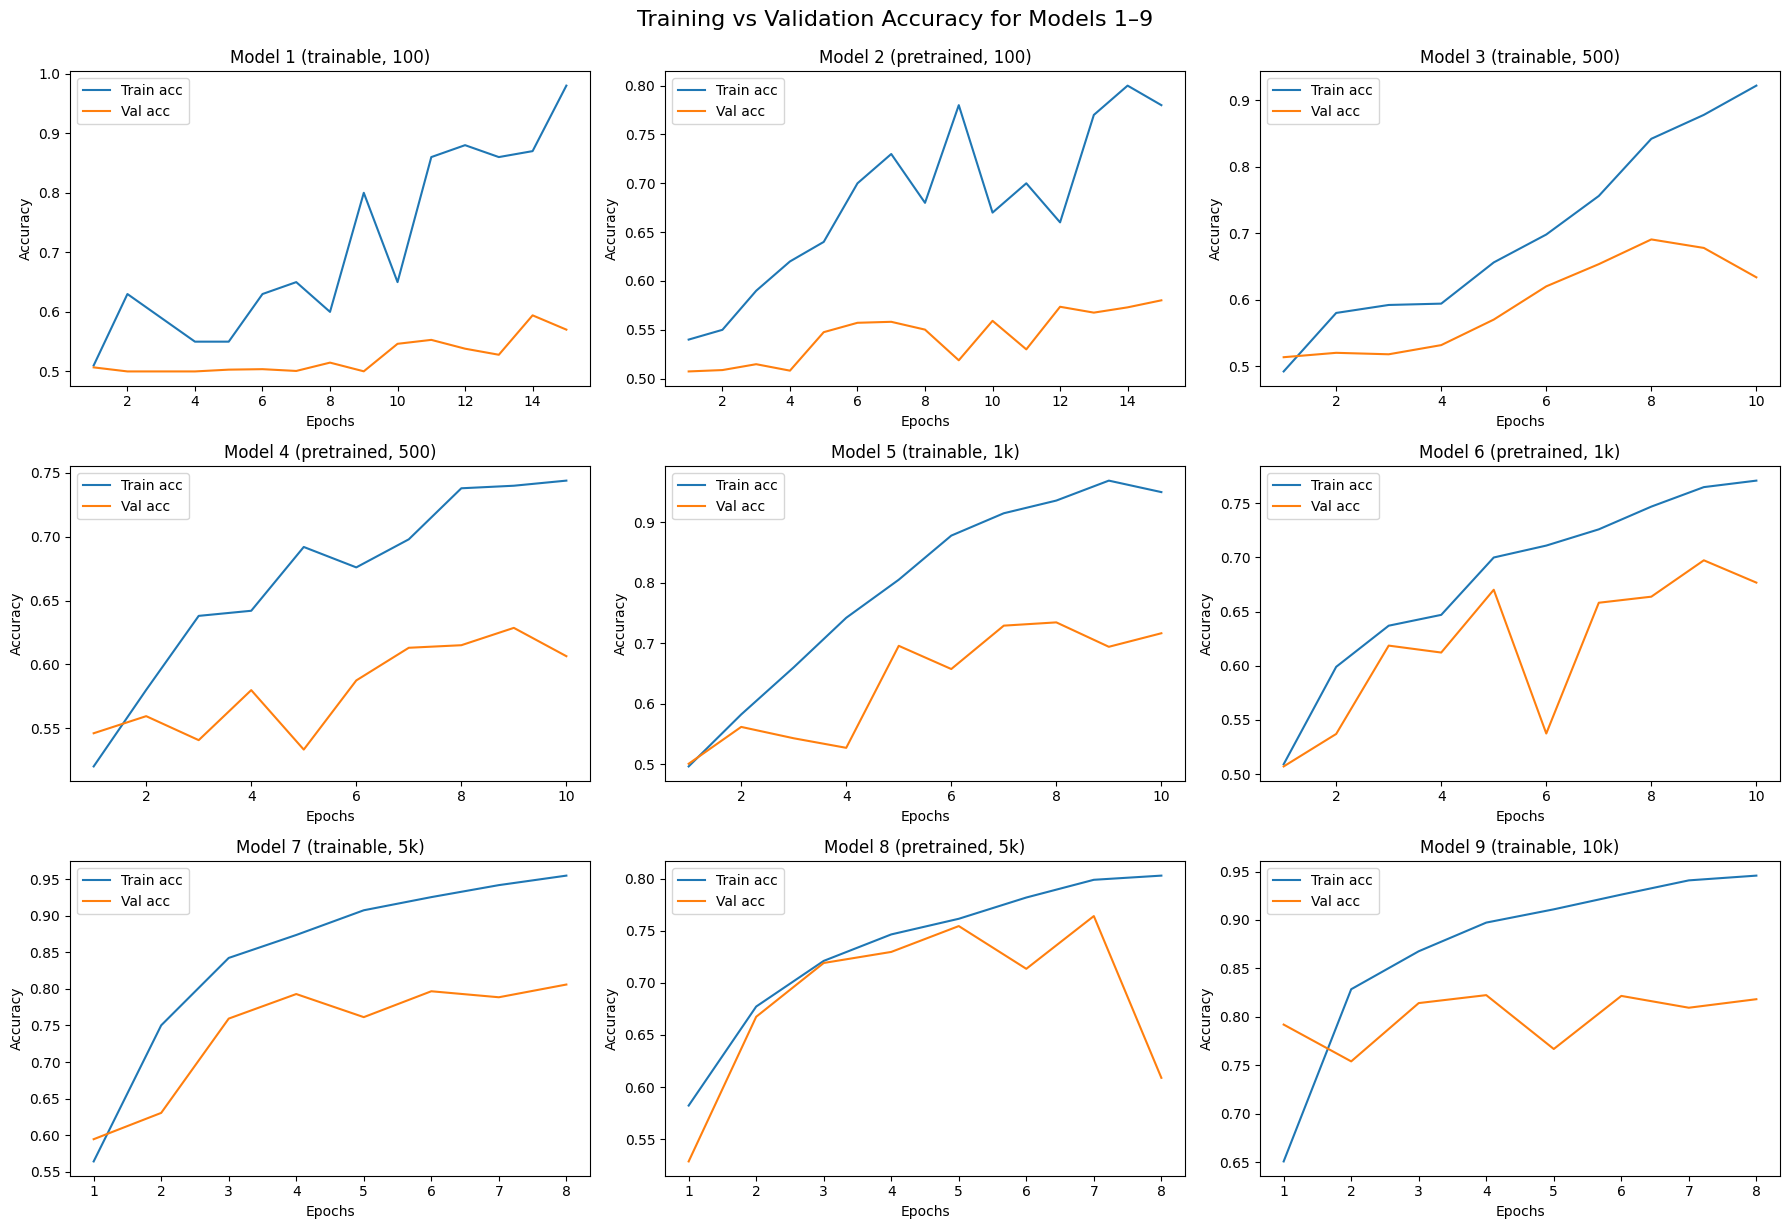

In [20]:
import matplotlib.pyplot as plt

histories = [history1, history2, history3, history4, history5, history6, history7, history8, history9]
labels    = [
    "Model 1 (trainable, 100)",
    "Model 2 (pretrained, 100)",
    "Model 3 (trainable, 500)",
    "Model 4 (pretrained, 500)",
    "Model 5 (trainable, 1k)",
    "Model 6 (pretrained, 1k)",
    "Model 7 (trainable, 5k)",
    "Model 8 (pretrained, 5k)",
    "Model 9 (trainable, 10k)",
]

plt.figure(figsize=(18, 12))
for i, (history, label) in enumerate(zip(histories, labels), start=1):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)

    plt.subplot(3, 3, i)
    plt.plot(epochs, acc, label="Train acc")
    plt.plot(epochs, val_acc, label="Val acc")
    plt.title(label)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()

plt.suptitle("Training vs Validation Accuracy for Models 1–9", y=1.02, fontsize=16)
plt.show()


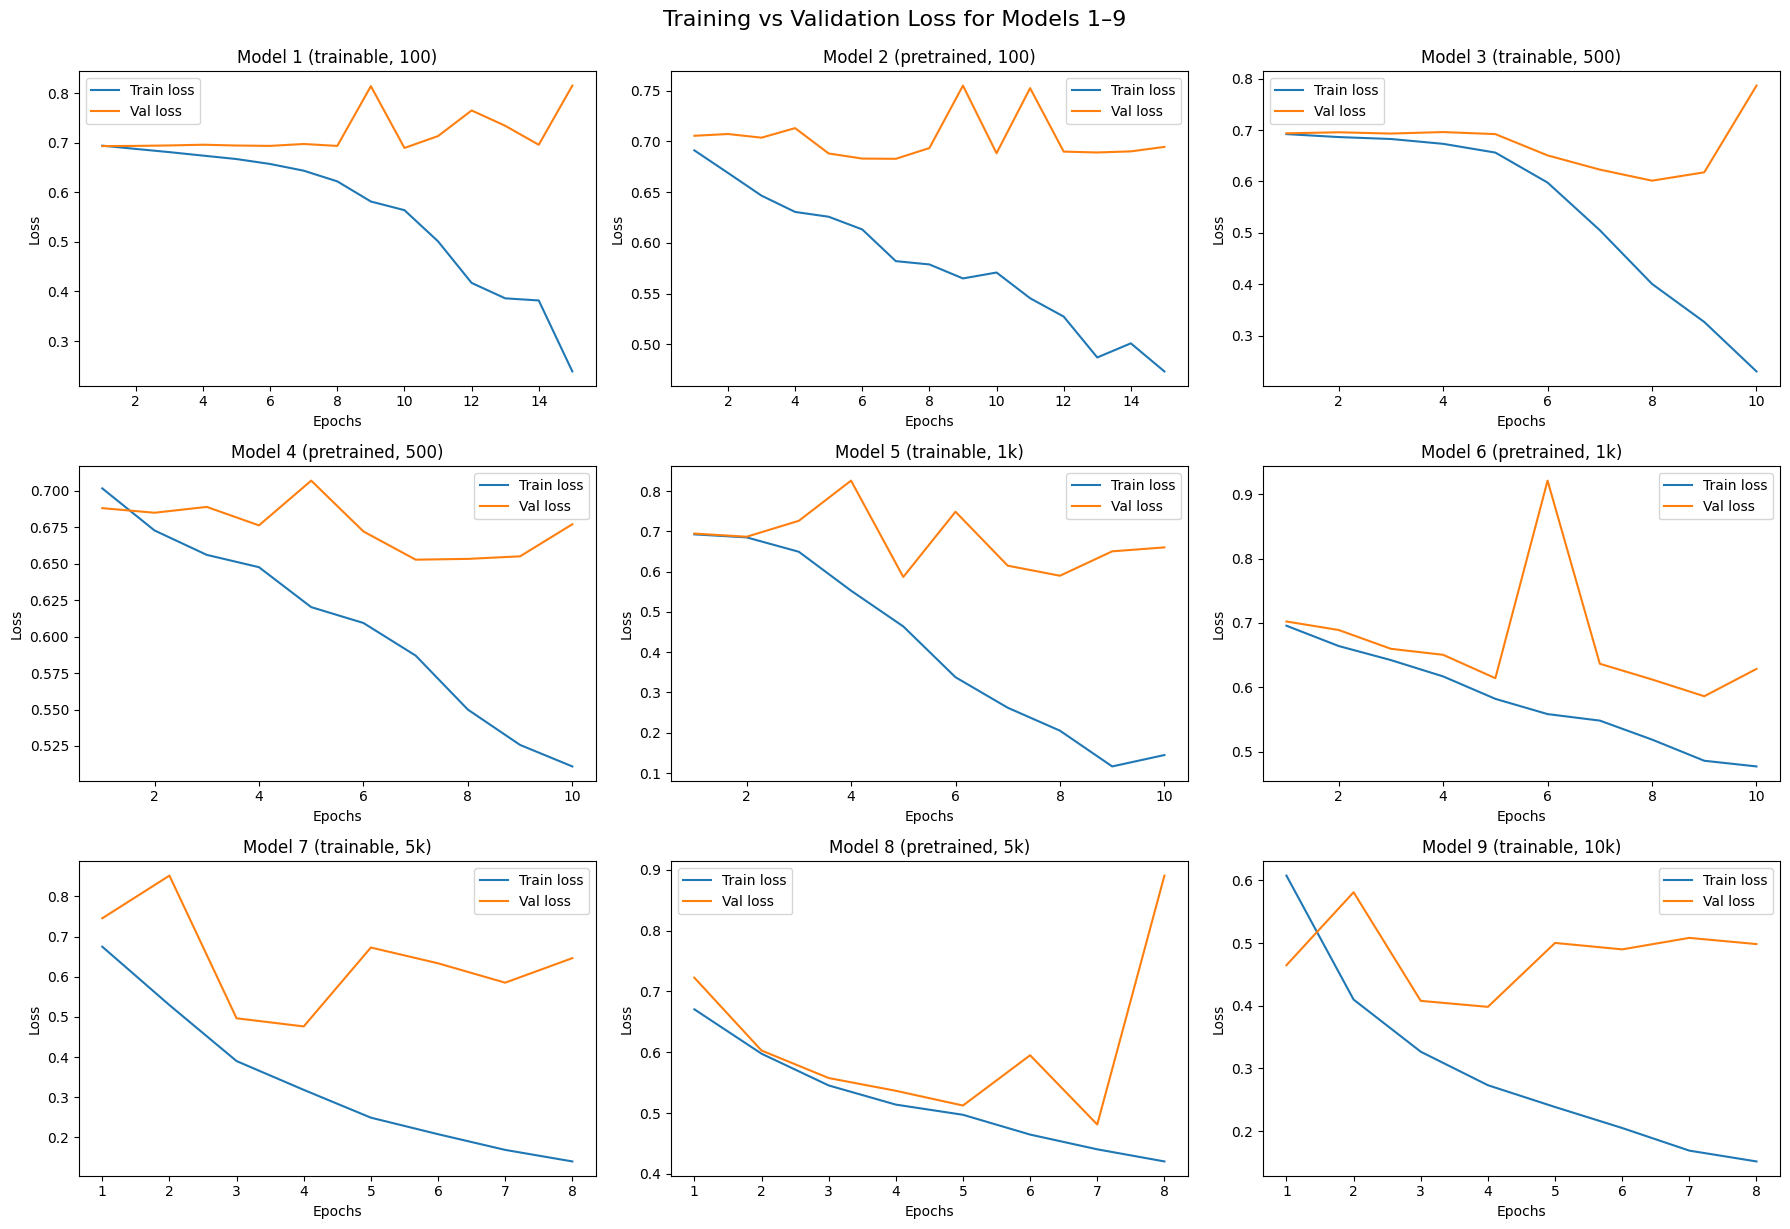

In [21]:
plt.figure(figsize=(18, 12))
for i, (history, label) in enumerate(zip(histories, labels), start=1):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)

    plt.subplot(3, 3, i)
    plt.plot(epochs, loss, label="Train loss")
    plt.plot(epochs, val_loss, label="Val loss")
    plt.title(label)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()

plt.suptitle("Training vs Validation Loss for Models 1–9", y=1.02, fontsize=16)
plt.show()


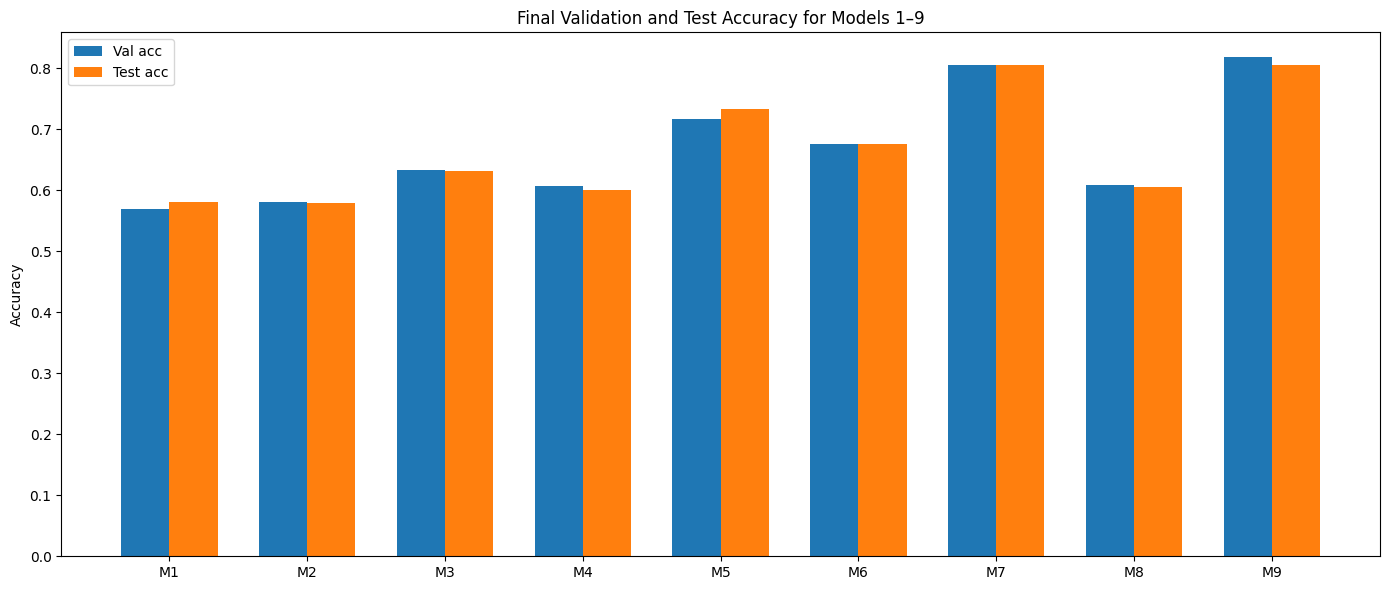

In [22]:
import numpy as np
import matplotlib.pyplot as plt

test_metrics = [
    test_metrics1, test_metrics2, test_metrics3,
    test_metrics4, test_metrics5, test_metrics6,
    test_metrics7, test_metrics8, test_metrics9
]

final_val_acc = [h.history["val_accuracy"][-1] for h in histories]
final_test_acc = [tm[1] for tm in test_metrics]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, final_val_acc, width, label="Val acc")
plt.bar(x + width/2, final_test_acc, width, label="Test acc")

plt.xticks(x, [f"M{i}" for i in range(1, 10)], rotation=0)
plt.ylabel("Accuracy")
plt.title("Final Validation and Test Accuracy for Models 1–9")
plt.legend()
plt.tight_layout()
plt.show()
